In [ ]:
!pip install stable-baselines3 gymnasium JaxFin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!pip install sbx-rl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: stable-baselines3
    Found existing installation: stable-baselines3 2.2.1
    Uninstalling stable-baselines3-2.2.1:
      Successfully uninstalled stable-baselines3-2.2.1


In [ ]:
from itertools import product

import numpy as np
from numpy.random import choice

from gymnasium import Env, spaces
from gymnasium.spaces import Box, Discrete
from gymnasium.wrappers import NormalizeObservation

from jax import vmap

from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.models.gbm import UnivGeometricBrownianMotion

import matplotlib.pyplot as plt

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from sbx import TD3

import pprint

import torch as th

SEED: int = 0

np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


## BS environment


In [ ]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))


def flatten(fn):
    def wrapper(*args, **kwargs):
        return fn(*args, **kwargs).flatten()

    return wrapper


class BlackScholesEnvBase(Env):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        self.s0 = s0
        self.strike = strike
        self.expiry = expiry
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = expiry / n_steps
        self._current_step = 0

        self.render_mode = "human"

        self._stock_path = np.array([])
        self._call_prices = np.array([])
        self._deltas = np.array([])

        self._hedging_portfolio_value = 0.0
        self._current_hedging_delta = 0.0
        self._previous_hedging_delta = 0.0
        self._back_account_value = 0.0
        self._ddelta = 0.0

        self._epsilon = 1
        self._lambda = 0.1
        self._tick_size = 0.01

    def reset(self, seed=None):
        super().reset(seed=seed)

        self._current_step = 0
        self._stock_path = self._generate_stock_path(seed=seed)
        self._call_prices = self._get_call_prices()
        self._deltas = self._get_deltas()
        self._hedging_portfolio_value = self._call_prices[0]
        self._current_hedging_delta = -self._deltas[0]
        self._back_account_value = (
            self._hedging_portfolio_value - self.current_hedging_delta * self.s0
        )

        observations = self._get_observations()
        infos = self._get_infos()

        return observations, infos

    def step(self, action: float):
        self._current_step += 1

        done = self._current_step == (self.n_steps - 1)
        reward = self._calculate_reward()

        self._hedging_portfolio_value = self._calculate_hedging_portfolio_value(action)

        observations = self._get_observations()
        infos = self._get_infos()
        self._update_delta(action)

        return observations, reward, done, False, infos

    def render(self, mode="human"):
        pass

    def _update_delta(self, new_delta: float):
        self._ddelta = new_delta - self.current_hedging_delta
        self._previous_hedging_delta = self.current_hedging_delta
        self.current_hedging_delta = new_delta

    def _calculate_reward(self) -> float:
        if self._current_step == 1:
            return - self._get_transaction_costs(self.current_hedging_delta)

        pnl = self._calculate_pnl()
        return pnl - self._lambda / 2 * pnl**2

    def _calculate_pnl(self) -> float:
        dv = (
            self._call_prices[self._current_step]
            - self._call_prices[self._current_step - 1]
        )
        ds = (
            self._stock_path[self._current_step]
            - self._stock_path[self._current_step - 1]
        )[0]
        ddelta = self._ddelta

        if self._current_step == (self.n_steps - 1):
            liquidation_value = self._get_transaction_costs(self.current_hedging_delta)
            return (
                dv
                + self.current_hedging_delta * ds
                - self._get_transaction_costs(ddelta)
                - liquidation_value
            )

        return (
            dv + self.current_hedging_delta * ds - self._get_transaction_costs(ddelta)
        )

    def _get_transaction_costs(self, ddelta: float):
        return self._epsilon * self._tick_size * (np.abs(ddelta) + 0.01 * ddelta**2)

    def _get_observations(self):
        log_price_strike = self._get_log_ratio()
        time_to_expiration = self.expiry
        bs_delta = self._deltas[self._current_step]
        call_price = self._call_prices[self._current_step]
        return np.asarray(
            [
                log_price_strike,
                self.sigma,
                time_to_expiration,
                bs_delta,
                call_price / self._call_prices[0],
                self.current_hedging_delta,
            ],
            dtype=np.float32,
        )

    def _get_infos(self):
        return {
            "price": self._call_prices[self._current_step],
            "time_to_expiration": self.expiry - self._current_step * self.dt,
            "bs_delta": self._deltas[self._current_step],
            "stock_price": self._get_current_stock_price(),
            "current_delta": self.current_hedging_delta,
            "log(S/K)": self._get_log_ratio(),
            "hedge_portfolio_value": self._hedging_portfolio_value,
            "bank_account": self._back_account_value,
        }

    @property
    def current_hedging_delta(self):
        return self._current_hedging_delta

    @current_hedging_delta.setter
    def current_hedging_delta(self, new_hedge: float):
        self._current_hedging_delta = new_hedge

    def _get_log_ratio(self):
        if self._current_step == -1:
            return np.log(self.s0 / self.strike)
        return np.log(self._stock_path[self._current_step, 0] / self.strike)

    def _generate_stock_path(self, seed=None) -> np.ndarray:
        if seed:
            seed = 0

        gbm = UnivGeometricBrownianMotion(self.s0, self.mu, self.sigma)

        return np.asarray(gbm.sample_paths(0, self.expiry, self.n_steps, 1))

    @flatten
    def _get_call_prices(self) -> np.ndarray:
        return np.asarray(
            [
                european_price(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )

    @flatten
    def _get_deltas(self) -> np.ndarray:
        return np.asarray(
            [
                v_delta_european(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )

    def _calculate_hedging_portfolio_value(self, new_delta: float):
        if self._current_step == 0:
            self._hedging_portfolio_value = self._call_prices[0]
            self._back_account_value = (
                self._hedging_portfolio_value - self._current_hedging_delta * self.s0
            )
            return self._hedging_portfolio_value

        new_hedging_port_value = (
            self._back_account_value
            + self._current_hedging_delta * self._get_current_stock_price()
        )
        self._back_account_value = (
            new_hedging_port_value - new_delta * self._get_current_stock_price()
        )

        return new_hedging_port_value

    def _get_current_stock_price(self):
        return self._stock_path[self._current_step, 0]


class BlackScholesEnvCont(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Box(low=-1.0, high=0.0, shape=(1,))
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: np.ndarray):
        new_hedge = action[0]
        return super().step(new_hedge)


class BlackScholesEnvDis(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Discrete(100)
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: float):
        return super().step(-(action / 100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
check_env(BlackScholesEnvCont(100, 100, 1.0, 0.0, 0.0, 0.2, 252))

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## T3D

In [ ]:
initial_prices = [80, 90, 100, 110, 120]
expires = [0.25, 0.5, 1.0, 2.0]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]
n_steps = [63, 126, 252, 504]

cartesian_product = list(product(initial_prices, expires, sigmas, n_steps))

In [ ]:
indexes = choice(np.asarray(range(len(cartesian_product))), 19, replace=False)
random_sample = np.asarray(cartesian_product)[indexes]

In [ ]:
r = 0.0
mu = 0.0

init_s0 = 100
init_K = 100
init_T = 1.0
init_vol = 0.2
init_n_steps = 252

n_episodes = 100

In [ ]:
def make_env(s0, strike, expiry, r, mu, vol, n_steps):
    def _create_env():
        return BlackScholesEnvCont(s0, strike, expiry, r, mu, vol, n_steps)
    return _create_env

def make_vec_env(s0: float, strike: float, expiry:float, r: float, mu: float, vol: float, n_steps: int) -> Env:
    vec_env = DummyVecEnv([make_env(s0, strike, expiry, r, mu, vol, n_steps) for _ in range(5)])
    return VecMonitor(vec_env, filename='./training.log')

In [ ]:
initial_env = make_vec_env(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)

In [ ]:
learning_rate = 0.001
batch_size = 64
gamma = 0.9999
train_freq = 100
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

model = TD3("MlpPolicy",
             initial_env,
             learning_rate=learning_rate,
             batch_size=batch_size,
             gamma=gamma,
             train_freq=train_freq,
             policy_kwargs=policy_kwargs,
             verbose=0)

## Training

In [ ]:
model.learn(total_timesteps=252*n_episodes, log_interval=10, progress_bar=True)

Output()

In [ ]:
training_rewards = [evaluate_policy(model, initial_env, n_eval_episodes=10)[0]]

In [ ]:
# train loop
for s0, T, vol, steps in random_sample:
    n_steps = int(steps)
    K = np.random.randint(low=int(s0 * 0.8), high=int(s0 * 1.2))
    print(f's0: {s0}, K: {K}, T: {T}, vol: {vol}, steps: {steps}')
    env = make_vec_env(s0, K, T, r, mu, vol, n_steps)
    model.set_env(env)
    model.learn(total_timesteps=n_steps*n_episodes, log_interval=10, progress_bar=True)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    training_rewards.append(mean_reward)
    print(f'Val reward: {mean_reward}')

s0: 90.0, K: 97, T: 1.0, vol: 0.4, steps: 63.0


Output()

Val reward: -6.573449611663818
s0: 110.0, K: 130, T: 2.0, vol: 0.3, steps: 126.0


Output()

Val reward: 1.743837594985962
s0: 120.0, K: 111, T: 0.5, vol: 0.1, steps: 126.0


Output()

Val reward: 2.769899368286133
s0: 100.0, K: 96, T: 0.5, vol: 0.5, steps: 63.0


Output()

Val reward: 3.8020126819610596
s0: 110.0, K: 111, T: 0.25, vol: 0.2, steps: 252.0


Output()

Val reward: -2.0047659873962402
s0: 80.0, K: 84, T: 2.0, vol: 0.1, steps: 63.0


Output()

Val reward: 2.5531201362609863
s0: 90.0, K: 86, T: 2.0, vol: 0.4, steps: 504.0


Output()

Val reward: 12.452169418334961
s0: 110.0, K: 101, T: 0.5, vol: 0.1, steps: 126.0


Output()

Val reward: 2.999764919281006
s0: 90.0, K: 99, T: 2.0, vol: 0.1, steps: 126.0


Output()

Val reward: 3.351525068283081
s0: 100.0, K: 113, T: 1.0, vol: 0.4, steps: 252.0


Output()

Val reward: -0.6764698028564453
s0: 80.0, K: 85, T: 0.5, vol: 0.5, steps: 126.0


Output()

Val reward: 4.313231945037842
s0: 90.0, K: 95, T: 1.0, vol: 0.4, steps: 252.0


Output()

Val reward: 1.3819025754928589
s0: 90.0, K: 78, T: 0.5, vol: 0.4, steps: 126.0


Output()

Val reward: 5.579888343811035
s0: 120.0, K: 129, T: 0.5, vol: 0.3, steps: 63.0


Output()

Val reward: 0.5191851854324341
s0: 80.0, K: 68, T: 0.25, vol: 0.4, steps: 63.0


Output()

Val reward: 3.4623827934265137
s0: 80.0, K: 94, T: 1.0, vol: 0.5, steps: 504.0


Output()

Val reward: 8.004752159118652
s0: 110.0, K: 111, T: 1.0, vol: 0.4, steps: 126.0


Output()

Val reward: 10.671625137329102
s0: 90.0, K: 91, T: 2.0, vol: 0.1, steps: 63.0


Output()

Val reward: 3.5927398204803467
s0: 100.0, K: 97, T: 1.0, vol: 0.2, steps: 252.0


Output()

Val reward: 2.0203843116760254


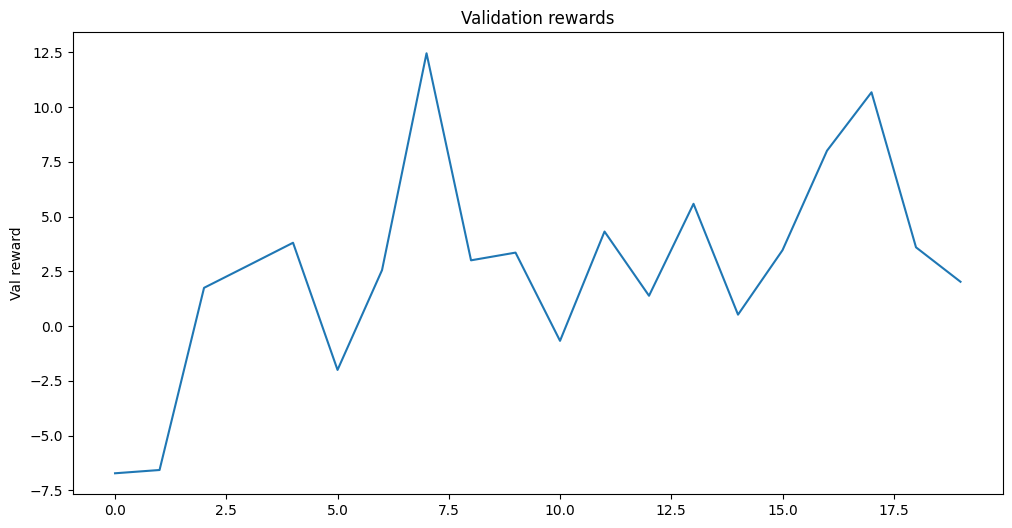

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(training_rewards)
plt.title('Validation rewards')
plt.ylabel('Val reward')
plt.show()

## Evaluation

In [ ]:
test_env = BlackScholesEnvCont(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)
obs, info = test_env.reset(seed=SEED)

pp = pprint.PrettyPrinter(indent=4)
log_infos = False

rewards = []
hedges = []
bs_deltas = []
hedge_port = []
call_price = []

for i in range(252):
    action, _states = model.predict(obs)

    obs, reward, done, _, info = test_env.step(action)

    rewards.append(reward)
    hedges.append(action)
    bs_deltas.append(info['bs_delta'])
    hedge_port.append(info['hedge_portfolio_value'])
    call_price.append(info['price'])

    if log_infos:
        print(f'Step: {i}')
        print('Action:', action)
        print('Observations:')
        pp.pprint(obs)
        print('Infos')
        pp.pprint(info)
        print('Reward:', reward)

    if done:
        obs, info = test_env.reset()

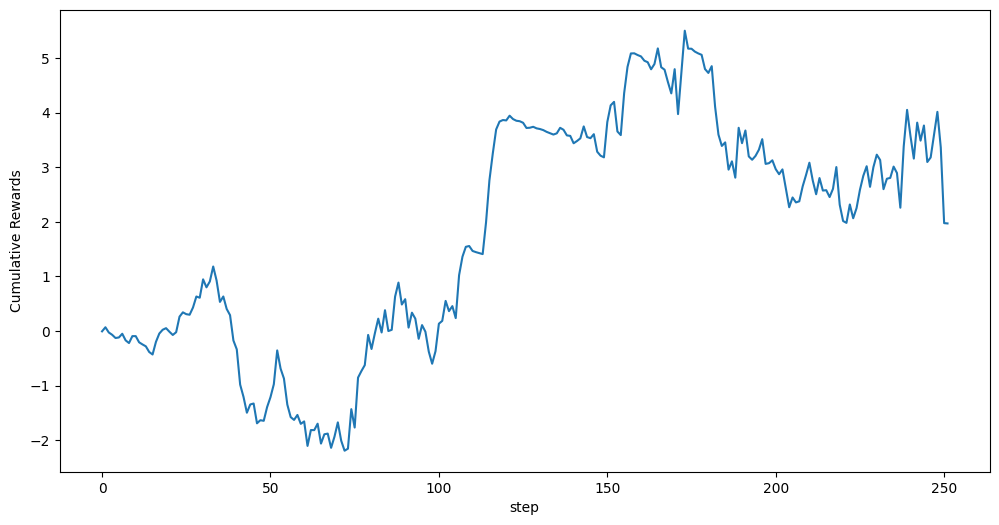

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(np.cumsum(rewards))
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

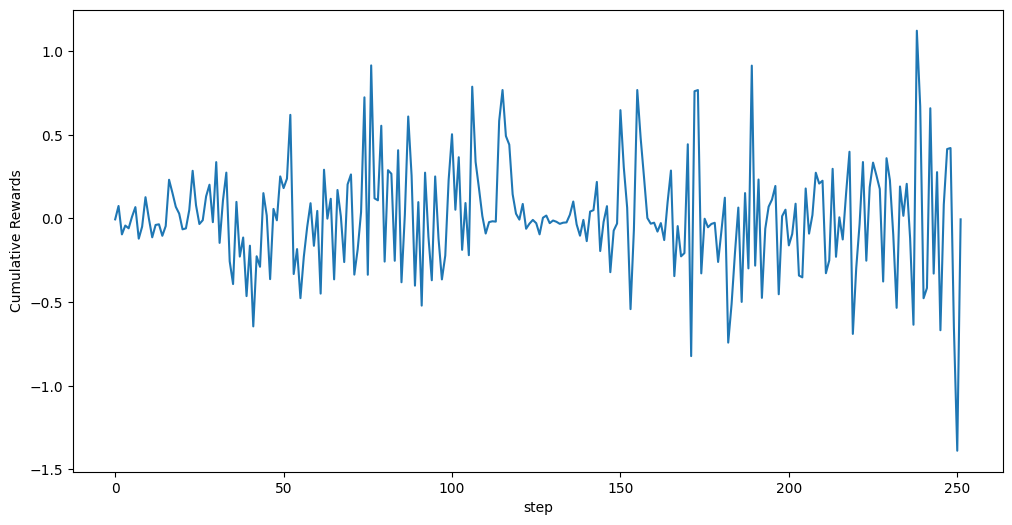

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(rewards)
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

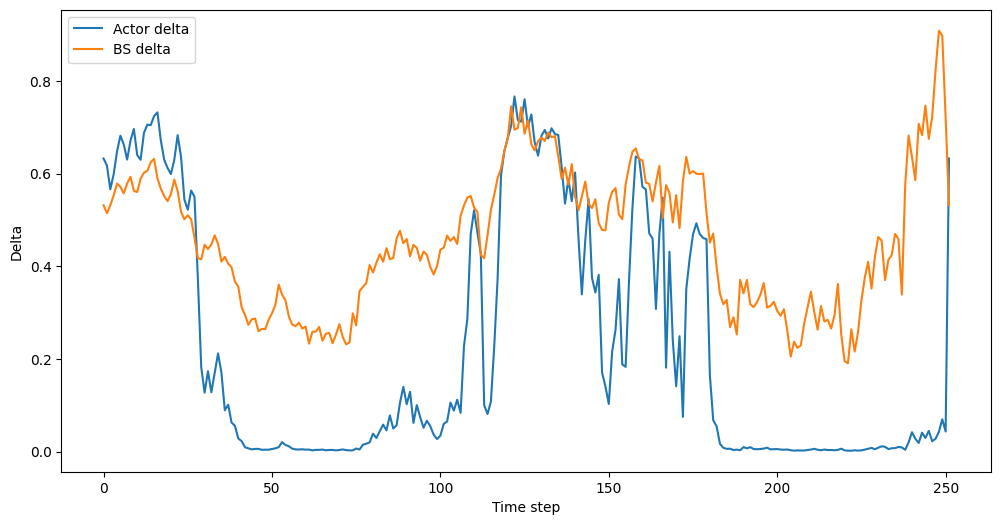

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(-np.array(hedges), label='Actor delta')
plt.plot(bs_deltas, label='BS delta')
plt.xlabel('Time step')
plt.ylabel('Delta')
plt.legend()
plt.show()

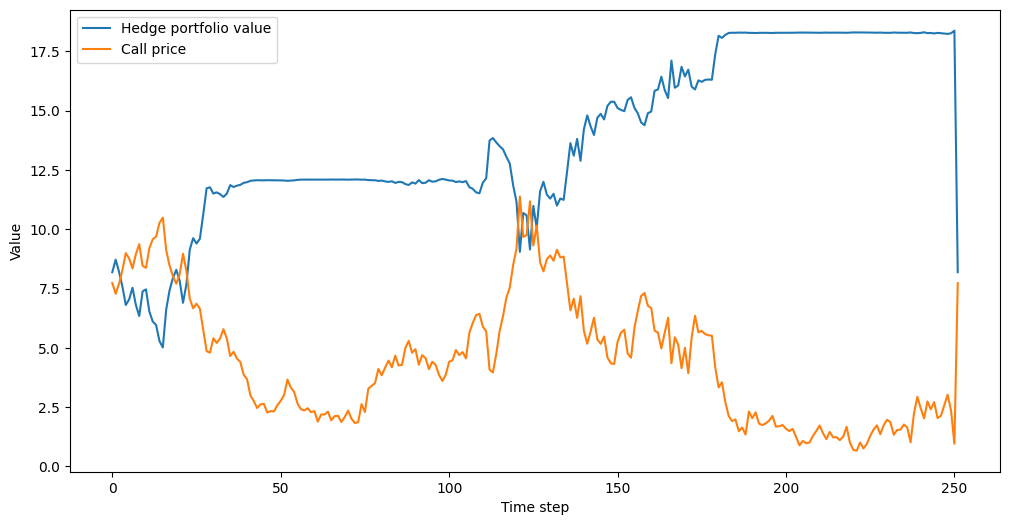

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.plot(hedge_port, label='Hedge portfolio value')
plt.plot(call_price, label='Call price')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show()